In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

org_heats_dir = "/home/lyuze/workspace/obj_heats"
interested_file = "matmul_list.txt"
org_heats_file = os.path.join(org_heats_dir, interested_file)

In [2]:
columns = ["timestamp", "addr", "type", "cur_size", "diff"]
org_df = pd.read_csv(org_heats_file, sep="\t", header=None, names=columns)
org_df['addr'] = org_df['addr'].apply(lambda x: int(x, 16)) # convert address to decimal

In [3]:
print(org_df['timestamp'].dtype)
print(org_df['addr'].dtype)
print(org_df['type'].dtype)
print(org_df['cur_size'].dtype)
print(org_df['diff'].dtype)

float64
int64
object
int64
int64


In [4]:
# 1. get all *live* unique objects per sampling period
def get_unqiue_obj(df):
    unique_objs_num = df['addr'].nunique()
    print("# unique objects:", unique_objs_num)
    grouped_orgdf = df.groupby('timestamp')
    total_obj_size_sample = []
    unique_objs_sample = [] # list to store all *live* objects thru exec
    ts_gap = []
    prev_ts = 0
    for ts, group_df in grouped_orgdf:
        cur_totol_size_mb = round(group_df['cur_size'].sum() / (1024*1024), 2)
        total_obj_size_sample.append(cur_totol_size_mb)
        unique_objs_sample.append(group_df['addr'].nunique())
        ts_gap.append(ts - prev_ts)
        prev_ts = ts
    ts_gap.pop(0) # delete the 1st elem in ts_gap
    avg_sample_dur = round(sum(ts_gap) / len(ts_gap), 2) # get the average of sample duration
    print("avg_sample_dur: ", avg_sample_dur)
    return unique_objs_sample, avg_sample_dur, total_obj_size_sample

# unique objects: 1608215
avg_sample_dur:  5.05
[973318, 992504, 1011731, 1033694, 1053722, 1074644, 1095543, 1119491, 1143676, 1173830, 1198970, 1232522, 1264092, 1288350, 1313418, 1338852, 1370238, 1396693, 1429150, 1462222, 1492964, 1524319, 1558869, 866536]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


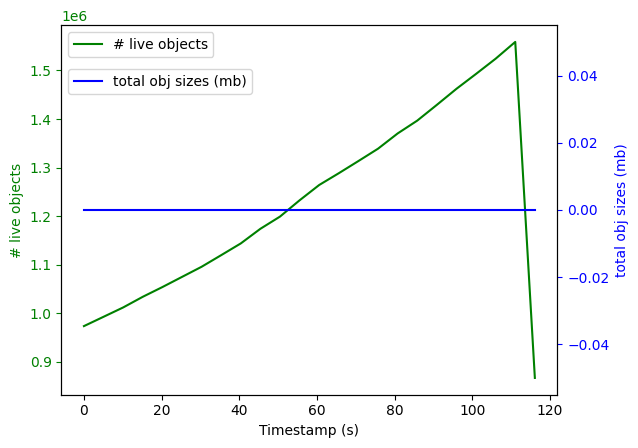

In [5]:
# 1.1 plot unique addresses VS time
y1, avg_sample_dur, y2 = get_unqiue_obj(org_df)
print(y1)
print(y2)
x_time = [i * avg_sample_dur for i in range(len(y1))]
fig, ax1 = plt.subplots()
ax1.plot(x_time, y1,'g-', label= '# live objects')
ax1.set_xlabel('Timestamp (s)')
ax1.set_ylabel('# live objects', color='g')
ax1.tick_params('y', colors='g')

ax2 = ax1.twinx()
ax2.plot(x_time, y2, 'b-', label='total obj sizes (mb)')
ax2.set_ylabel('total obj sizes (mb)', color='b')
ax2.tick_params('y', colors='b')

legend1 = ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1))
legend2 = ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 0.9))

# # plot single plot
# plt.plot(x_time, unique_objs_sample)
# plt.xlabel('Timestamp (s)')
# plt.ylabel('# Objects')
# plt.title('# of objects with time')
# plt.savefig("live_unique_objs.png")

In [6]:
# 2. get all *active* unique objects 
filtered_df_no_zeros = org_df[(org_df["diff"] != 0)]
condition_no93 = filtered_df_no_zeros['addr'].astype(str).str.startswith('93')
filtered_df_no_zeros = filtered_df_no_zeros[~condition_no93]
filtered_df_no_zeros_files = os.path.join(org_heats_dir, "matmul_list_no_zeros.txt")
filtered_df_no_zeros.to_csv(filtered_df_no_zeros_files, sep='\t', index=False, header=False)

most_frequent_value = filtered_df_no_zeros['addr'].mode().values
print(most_frequent_value[0])
# print(most_frequent_value[1])

y1, avg_sample_dur, y2 = get_unqiue_obj(filtered_df_no_zeros)
print(y2)
x_time = [i * avg_sample_dur for i in range(len(y1))]
fig, ax1 = plt.subplots()
plt.title('# of objects and total obj sizes with time')
ax1.plot(x_time, y1,'g-', label= '# live objects')
ax1.set_xlabel('Timestamp (s)')
ax1.set_ylabel('# live objects', color='g')
ax1.tick_params('y', colors='g')

ax2 = ax1.twinx()
ax2.plot(x_time, y2, 'b-', label='total obj sizes (mb)')
ax2.set_ylabel('total obj sizes (mb)', color='b')
ax2.tick_params('y', colors='b')

legend1 = ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1))
legend2 = ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 0.9))

# plt.plot(x_time, y1)
# plt.xlabel('Timestamp (s)')
# plt.ylabel('# Objects')
# plt.title('# of objects with time')
# plt.savefig("active_unique_objs.png")

140737283097504


IndexError: index 1 is out of bounds for axis 0 with size 1

# unique objects: 17
avg_sample_dur:  1.0
[3, 3, 3, 3, 2, 2, 1, 1, 4, 4]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


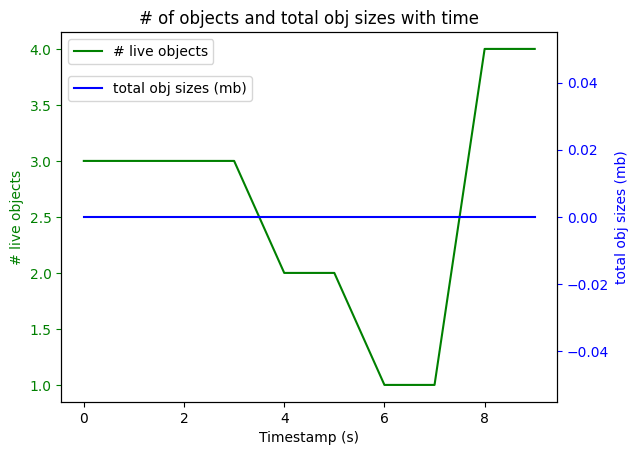

In [ ]:
# filter out both 0 and 1 increment
filtered_df_no_zeros_ones = org_df[(org_df["diff"] != 0) & (org_df["diff"] != 1) & (org_df["diff"] != -1)]
condition_no93 = filtered_df_no_zeros_ones['addr'].astype(str).str.startswith('93')
filtered_df_no_zeros_ones = filtered_df_no_zeros_ones[~condition_no93]
filtered_df_no_zeros_ones_files = os.path.join(org_heats_dir, "matmul_list_no_zeros_ones.txt")
filtered_df_no_zeros_ones.to_csv(filtered_df_no_zeros_ones_files, sep='\t', index=False, header=False)

y1, avg_sample_dur, y2 = get_unqiue_obj(filtered_df_no_zeros_ones)
print(y1)
print(y2)
x_time = [i * avg_sample_dur for i in range(len(y1))]
fig, ax1 = plt.subplots()
plt.title('# of objects and total obj sizes with time')
ax1.plot(x_time, y1,'g-', label= '# live objects')
ax1.set_xlabel('Timestamp (s)')
ax1.set_ylabel('# live objects', color='g')
ax1.tick_params('y', colors='g')

ax2 = ax1.twinx()
ax2.plot(x_time, y2, 'b-', label='total obj sizes (mb)')
ax2.set_ylabel('total obj sizes (mb)', color='b')
ax2.tick_params('y', colors='b')

legend1 = ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1))
legend2 = ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 0.9))

Min addr: 140737337963280
Max addr: 140737352876656
address range: 14.2


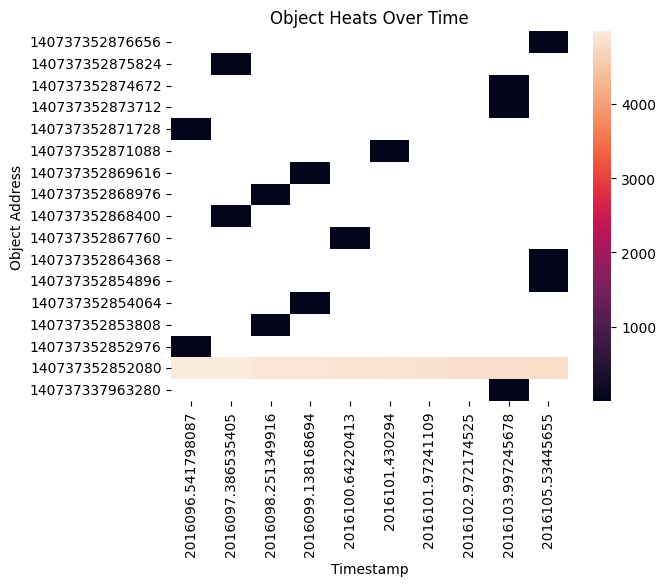

In [ ]:
import pandas as pd
import seaborn
# import matplotlib.pyplot as plt|
data = {
    'timestamp': ['124.11', '124.11', '124.11', '124.12', '124.12', '124.12'],
    'addr': [1, 2, 100, 1, 2, 100],
    'diff': [0.1, 0.2, 0.3, -0.2, 0.3, 0.7]
}

columns = ["timestamp", "addr", "type", "cur_size", "diff"]
filtered_df_no_zeros_ones = pd.read_csv("/home/lyuze/workspace/obj_heats/matmul_list_no_zeros_ones.txt", sep="\t", header=None, names=columns)

filtered_df_no_zeros_ones['diff'] = filtered_df_no_zeros_ones['diff'].abs()
min_ = filtered_df_no_zeros_ones["addr"].min()
max_ = filtered_df_no_zeros_ones["addr"].max()
print("Min addr:", min_)
print("Max addr:", max_)
addr_range = (max_ - min_) / (1024*1024)
print("address range: {:.1f}".format(addr_range))

# df = pd.DataFrame(data)
heatmap_data = filtered_df_no_zeros_ones.pivot(index='addr', columns='timestamp', values='diff')
# plt.figure(figsize=(10, 6))  # Optional: set the figure size

# Customize the heatmap style and appearance as needed
# seaborn.set()  # Set Seaborn styling
seaborn.heatmap(heatmap_data, annot=False, cbar=True, robust=True)
#  cmap='YlGnBu'
plt.gca().invert_yaxis()
# Set labels and title
plt.xlabel("Timestamp")
plt.ylabel("Object Address")
plt.title("Object Heats Over Time")

# Show the heatmap
plt.show()
